In [1]:
import numpy as np
from ct_support_code import *
import matplotlib.pyplot as plt

data = np.load('ct_data.npz')
X_train = data['X_train']; X_val = data['X_val']; X_test = data['X_test']
y_train = data['y_train']; y_val = data['y_val']; y_test = data['y_test']

In [2]:
# 1 a)
y_train_mean = y_train.mean()
print('y_train mean: ', y_train_mean)

y_val_mean = y_val.mean()
y_val_error = y_val.std()/np.sqrt(len(y_val))

y_train_error = y_train[:5785].std()/np.sqrt(5785)
print(f'y_val mean with standard error: {y_val_mean} ± {y_val_error}')
print(f'y_train 5785 samples mean with standard error: {y_train[:5785].mean()} ± {y_train_error}')

"""
We see that y_train mean with the error bar for
only 5785 samples is far away from zero (y_train mean).
As number of samples in y_train is much larger than number of samples in y_val,
we can't make our predictions of y_val mean just based on y_train mean 
with the standard error bar...better explanation..
"""

y_train mean:  -9.13868774539957e-15
y_val mean with standard error: -0.2160085093241599 ± 0.012903383410668334
y_train 5785 samples mean with standard error: -0.44247687859693674 ± 0.01192627246273395


"\nWe see that y_train mean with the error bar for\nonly 5785 samples is far away from zero (y_train mean).\nAs number of samples in y_train is much larger than number of samples in y_val,\nwe can't make our predictions of y_val mean just based on y_train mean \nwith the standard error bar...better explanation..\n"

In [3]:
# 1 b)

remove_indexes = [i for i,col in enumerate(X_train.T) if np.all(col==col[0])]
print('Indexes of constant columns:', remove_indexes)
remove_indexes_2 = []
for i, col1 in enumerate(X_train.T):
    for j, col2 in enumerate(X_train.T[i+1:,:]):
        if np.all(col1==col2):
            remove_indexes_2.append(i+j+1)
            break       
print('Original indexes of duplicate columns', remove_indexes_2)
remove_indexes = remove_indexes + remove_indexes_2
X_train = np.delete(X_train, remove_indexes, axis=1)
X_val = np.delete(X_val, remove_indexes, axis=1)
X_test = np.delete(X_test, remove_indexes, axis=1)

Indexes of constant columns: [59, 69, 179, 189, 351]
Original indexes of duplicate columns [78, 79, 69, 179, 199, 188, 189, 351, 287, 359]


In [5]:
# 2 
def fit_linreg(X, yy, alpha):
    K = X.shape[1]
    N = X.shape[0]
    X = np.column_stack((X,np.ones(N)))
    X = np.row_stack((X,np.sqrt(alpha)*np.eye(K+1)))
    y = np.concatenate((yy, np.zeros(K+1)))
    w = np.linalg.lstsq(X,y,rcond=None)[0]
    return w[:-1], w[-1]

def rmse(ww, bb, XX, yy):
    return np.sqrt(np.mean(((XX @ ww + bb) - yy)**2))

alpha = 30
train_w1, train_b1 = fit_linreg(X_train, y_train, alpha)
train_w2, train_b2 = fit_linreg_gradopt(X_train, y_train, alpha)
print('Training RMSE (fit_linreg): ', rmse(train_w1, train_b1, X_train, y_train))
print('Training RMSE (fit_linreg_gradopt): ', rmse(train_w2, train_b2, X_train, y_train))
print('Validation RMSE (fit_linreg): ', rmse(train_w1, train_b1, X_val, y_val))
print('Validation RMSE (fit_linreg_gradopt): ', rmse(train_w2, train_b2, X_val, y_val))

"""
Values close to each other, but not exactly the same
fit_linreg_gradopt is better on training
Add explanation..numerical reasons..different method?
val rmse smaller..?
"""

Training RMSE (fit_linreg):  0.3567669814948786
Training RMSE (fit_linreg_gradopt):  0.35675561493545876
Validation RMSE (fit_linreg):  0.42292954946321326
Validation RMSE (fit_linreg_gradopt):  0.42305590683687927


'\nValues close to each other, but not exactly the same\nfit_linreg_gradopt is better on training\nAdd explanation..numerical reasons..different method?\nval rmse smaller..?\n'

In [6]:
# 3
K = 20 # number of thresholded classification problems to fit
mx = np.max(y_train); mn = np.min(y_train); hh = (mx-mn)/(K+1)
thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)


def fit_logreg_gradopt(X, yy, alpha):
    D = X.shape[1]
    args = (X, yy, alpha)
    init = (np.zeros(D), np.array(0))
    ww, bb = minimize_list(logreg_cost, init, args)
    return ww, bb

def logreg_forward(X, ww, bb):
    aa = (X @ ww) + bb
    return 1 / (1 + np.exp(-aa))

N = X_train.shape[0]
D = X_train.shape[1]
WW = np.empty((D, K))
BB = np.empty(K)
LL = np.empty((N, K))
for kk in range(K):
    labels = y_train > thresholds[kk]
    LL[:, kk] = labels
    WW[:,kk], BB[kk] = fit_logreg_gradopt(X_train, labels, alpha)


X_train_logreg = logreg_forward(X_train, WW, BB) 
X_val_logreg = logreg_forward(X_val, WW, BB) 

train_w_lr, train_b_lr = fit_linreg_gradopt(X_train_logreg, y_train, alpha)
print('Training RMSE logreg transformation (fit_linreg_gradopt): ', 
      rmse(train_w_lr, train_b_lr, X_train_logreg, y_train))
print('Validation RMSE logreg transformation (fit_linreg_gradopt): ', 
      rmse(train_w_lr, train_b_lr, X_val_logreg, y_val))
""" Lower RMSE than normal linear regression """

Training RMSE logreg transformation (fit_linreg_gradopt):  0.15441194427307056
Validation RMSE logreg transformation (fit_linreg_gradopt):  0.2542485765839827


' Lower RMSE than normal linear regression '

In [7]:
# 4
def fit_nn_gradopt(X, yy, alpha, K=20, init=None):
    D = X.shape[1]
    args = (X, yy, alpha)
    if init==None:
        init = (0.1*np.random.normal(0, 1/np.sqrt(K), size=K), np.array(0), 
                0.1*np.random.normal(0, 1/np.sqrt(D), size=(K, D)), np.zeros(K))
    ww, bb, V, bk = minimize_list(nn_cost, init, args)
    return ww, bb, V, bk

def nn_rmse(params, XX, yy):
    ww, bb, V, bk = params
    
    A = np.dot(XX, V.T) + bk[None,:] # N,K
    P = 1 / (1 + np.exp(-A)) # N,K
    F = np.dot(P, ww) + bb # N,
    E =  np.sqrt(np.mean((F - yy)**2))
    return E

nn_rand_params = fit_nn_gradopt(X_train, y_train, 30)
q3_params = (train_w_lr, train_b_lr, WW.T, BB)
nn_q3_params = fit_nn_gradopt(X_train, y_train, 30, init=q3_params)
print("NN train RMSE with random initialization parameters: ", nn_rmse(nn_rand_params, X_train, y_train))
print("NN train RMSE with q3 initialization parameters: ", nn_rmse(nn_q3_params, X_train, y_train))
print("NN val RMSE with random initialization parameters: ", nn_rmse(nn_rand_params, X_val, y_val))
print("NN val RMSE with q3 initialization parameters: ", nn_rmse(nn_q3_params, X_val, y_val))

NN train RMSE with random initialization parameters:  0.14112490248734788
NN train RMSE with q3 initialization parameters:  0.139174655128703
NN val RMSE with random initialization parameters:  0.2799943120555435
NN val RMSE with q3 initialization parameters:  0.27061551181673776


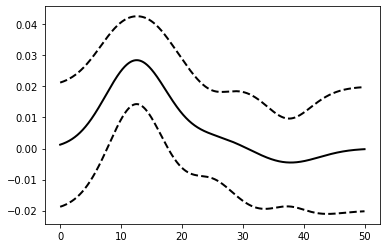

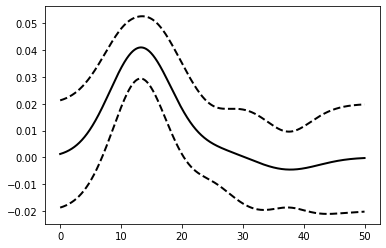

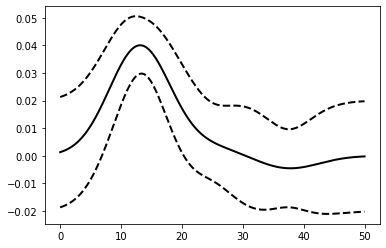

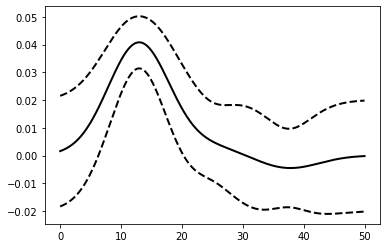

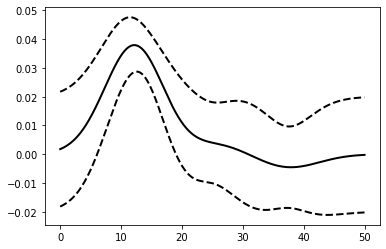

Best alpha:  13.68
Val RMSE:  0.2585916478634066
Test RMSE:  0.2946914803931076


In [16]:
# 5

def train_nn_reg(X_train, y_train, X_val, y_val, alpha):
    params = fit_nn_gradopt(X_train, y_train, alpha)
    return nn_rmse(params, X_val, y_val)

def prob_imp(mu, cov, yy, alphas, alpha):
    a_idx = np.where(alphas==alpha)[0][0]
    pi = norm.cdf((mu[a_idx]-np.max(yy))/np.sqrt(cov[a_idx,a_idx]))
    #pi = (mu[a_idx] - np.max(yy)) / np.sqrt(cov[a_idx, a_idx])
    return pi

alphas = np.arange(0, 50, 0.02)
idx = np.round(len(alphas)*np.array([0.25,0.5,0.75])).astype(int)
y_train_gp = np.array([])
train_alphas = alphas[idx]
for alpha in train_alphas:
    y_train_gp = np.append(y_train_gp, -np.log(train_nn_reg(X_train, y_train, X_val, y_val, alpha)))
nn_rand_params = fit_nn_gradopt(X_train, y_train, 30)
baseline = np.log(nn_rmse(nn_rand_params, X_val, y_val))
y_train_gp = baseline + y_train_gp
test_alphas = np.delete(alphas, idx)

for i in range(5):
    mu, cov = gp_post_par(test_alphas, train_alphas, y_train_gp)

    plt.plot(test_alphas, mu, '-k', linewidth=2)
    std = np.sqrt(np.diag(cov))
    plt.plot(test_alphas, mu + 2 * std, '--k', linewidth=2)
    plt.plot(test_alphas, mu - 2 * std, '--k', linewidth=2)
    plt.show()

    best_alpha = test_alphas[0]
    best_pi = - 1e100
    for alpha in test_alphas:
        pi = prob_imp(mu, cov, y_train_gp, test_alphas, alpha)
        if pi > best_pi:
            best_pi = pi
            best_alpha = alpha
    #print(best_alpha, best_pi)
    train_alphas = np.append(train_alphas, best_alpha)
    test_alphas = np.delete(test_alphas, np.where(test_alphas==best_alpha))
    #y_train_gp = np.append(y_train_gp, - np.log(train_nn_reg(X_train, y_train, X_val, y_val, best_alpha)))
    y_train_gp = np.append(y_train_gp, baseline -np.log(train_nn_reg(X_train, y_train, X_val, y_val, best_alpha)))
best_alpha = train_alphas[np.argmax(y_train_gp)]

val_rmse = train_nn_reg(X_train, y_train, X_val, y_val, best_alpha)
test_rmse = train_nn_reg(X_train, y_train, X_test, y_test, best_alpha)
#print(train_alphas)
print('Best alpha: ', best_alpha)
print('Val RMSE: ', val_rmse)
print('Test RMSE: ', test_rmse)

In [ ]:
from ct_support_code import *
def fit_logreg_gradopt(X, yy, alpha):
    D = X.shape[1]
    args = (X, yy, alpha)
    init = (np.zeros(D), np.array(0))
    ww, bb = minimize_list(logreg_cost, init, args)
    return ww, bb
    
def logreg_forward(X, ww, bb):
    aa = (X @ ww) + bb
    return 1 / (1 + np.exp(-aa))

def train_nn_reg(X_train, y_train, X_val, y_val, K, alpha=6.44):
    mx = np.max(y_train); mn = np.min(y_train); hh = (mx-mn)/(K+1)
    thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)
    
    N = X_train.shape[0]
    D = X_train.shape[1]
    WW = np.empty((D, K))
    BB = np.empty(K)
    for kk in range(K):
        labels = y_train > thresholds[kk]
        WW[:,kk], BB[kk] = fit_logreg_gradopt(X_train, labels, alpha)
    
    X_train_logreg = logreg_forward(X_train, WW, BB) 
    X_val_logreg = logreg_forward(X_val, WW, BB) 
    
    train_w_lr, train_b_lr = fit_linreg_gradopt(X_train_logreg, y_train, alpha)
    return  rmse(train_w_lr, train_b_lr, X_val_logreg, y_val)

def prob_imp(mu, cov, yy, alphas, alpha):
    a_idx = np.where(alphas==alpha)[0][0]
    pi = norm.cdf((mu[a_idx]-np.max(yy))/np.sqrt(cov[a_idx,a_idx]))
    #pi = (mu[a_idx] - np.max(yy)) / np.sqrt(cov[a_idx, a_idx])
    return pi

alphas = np.arange(10, 40, 1)
idx = np.round(len(alphas)*np.array([0.25,0.5,0.75])).astype(int)
y_train_gp = np.array([])
train_alphas = alphas[idx]
for alpha in train_alphas:
    y_train_gp = np.append(y_train_gp, -np.log(train_nn_reg(X_train, y_train, X_val, y_val, alpha)))
nn_rand_params = fit_nn_gradopt(X_train, y_train, 30)
baseline = np.log(nn_rmse(nn_rand_params, X_val, y_val))
y_train_gp = baseline + y_train_gp
test_alphas = np.delete(alphas, idx)

for i in range(5):
    mu, cov = gp_post_par(test_alphas, train_alphas, y_train_gp)

    plt.plot(test_alphas, mu, '-k', linewidth=2)
    std = np.sqrt(np.diag(cov))
    plt.plot(test_alphas, mu + 2 * std, '--k', linewidth=2)
    plt.plot(test_alphas, mu - 2 * std, '--k', linewidth=2)
    plt.show()

    best_alpha = test_alphas[0]
    best_pi = - 1e100
    for alpha in test_alphas:
        pi = prob_imp(mu, cov, y_train_gp, test_alphas, alpha)
        if pi > best_pi:
            best_pi = pi
            best_alpha = alpha
    print(best_alpha, best_pi)
    train_alphas = np.append(train_alphas, best_alpha)
    test_alphas = np.delete(test_alphas, np.where(test_alphas==best_alpha))
    #y_train_gp = np.append(y_train_gp, - np.log(train_nn_reg(X_train, y_train, X_val, y_val, best_alpha)))
    y_train_gp = np.append(y_train_gp, baseline -np.log(train_nn_reg(X_train, y_train, X_val, y_val, best_alpha)))
best_alpha = train_alphas[np.argmax(y_train_gp)]

val_rmse = train_nn_reg(X_train, y_train, X_val, y_val, best_alpha)
test_rmse = train_nn_reg(X_train, y_train, X_test, y_test, best_alpha)
#print(train_alphas)
print('Best alpha: ', best_alpha)
print('Val RMSE: ', val_rmse)
print('Test RMSE: ', test_rmse)

In [11]:
import copy
#6


def gp_post_par(X_rest, X_obs, yy, sigma_y=0.01, ell=5.0, sigma_f=0.01):
    """GP_POST_PAR means and covariances of a posterior Gaussian process

         rest_cond_mu, rest_cond_cov = gp_post_par(X_rest, X_obs, yy)
         rest_cond_mu, rest_cond_cov = gp_post_par(X_rest, X_obs, yy, sigma_y, ell, sigma_f)

     Calculate the means and covariances at all test locations of the posterior Gaussian
     process conditioned on the observations yy at observed locations X_obs.

     Inputs:
                 X_rest GP test locations
                  X_obs locations of observations
                     yy observed values
                sigma_y observation noise standard deviation
                    ell kernel function length scale
                sigma_f kernel function standard deviation

     Outputs:
           rest_cond_mu mean at each location in X_rest
          rest_cond_cov covariance matrix between function values at all test locations
    """
    #X_rest = X_rest[:, None]
    #X_obs = X_obs[:, None]
    K_rest = gauss_kernel_fn(X_rest, X_rest, ell, sigma_f)
    K_rest_obs = gauss_kernel_fn(X_rest, X_obs, ell, sigma_f)
    K_obs = gauss_kernel_fn(X_obs, X_obs, ell, sigma_f)
    M = K_obs + sigma_y**2 * np.eye(yy.size)
    M_cho, M_low = cho_factor(M)
    rest_cond_mu = np.dot(K_rest_obs, cho_solve((M_cho, M_low), yy))
    rest_cond_cov = K_rest - np.dot(K_rest_obs, cho_solve((M_cho, M_low), K_rest_obs.T))

    return rest_cond_mu, rest_cond_cov

def train_nn_reg(X_train, y_train, X_val, y_val, alpha, negval, init):
    X_train = copy.deepcopy(X_train)
    #X_train[X_train==-0.25] = negval
    params = fit_nn_gradopt(X_train, y_train, alpha, negval, init=init)
    return nn_rmse(params, X_val, y_val)

def prob_imp2(mu, cov, yy, i):
#    a_idx = np.where(alphas==alpha)[0][0]
#    n_idx = np.where(negvals==negval)[0][0]
#    final_idx = a_idx*len(negvals) + n_idx
    
    pi = norm.cdf((mu[i]-np.max(yy))/np.sqrt(cov[i,i]))
    #pi = (mu[i]-np.max(yy))/np.sqrt(cov[i,i])
    #pi = (mu[a_idx] - np.max(yy)) / np.sqrt(cov[a_idx, a_idx])
    return pi

#alphas = np.arange(0, 50, 0.02)
alphas = np.arange(0, 25, 1)
negvals = np.arange(15, 30, 1)
idx_alpha = np.round(len(alphas)*np.array([0.25,0.5,0.75])).astype(int)
idx_negval = np.round(len(negvals)*np.array([0.25,0.5,0.75])).astype(int)
#idx_alpha = np.round(len(alphas)*np.array([0.5])).astype(int)
#idx_negval = np.round(len(negvals)*np.array([0.5])).astype(int)
y_train_gp = np.array([])
train_alphas = alphas[idx_alpha]
train_negval = negvals[idx_negval]
x,y = np.meshgrid(train_alphas, train_negval)
X_obs = np.array([x.flatten(), y.flatten()]).T

for p in X_obs: #alpha in train_alphas:
    #for negval in train_negval:
    alpha = p[0]
    negval = p[1]
    print(p)
    y_train_gp = np.append(y_train_gp, -np.log(train_nn_reg(X_train, y_train, X_val, y_val, alpha, negval, q3_params)))
nn_rand_params = fit_nn_gradopt(X_train, y_train, 30)
baseline = np.log(nn_rmse(nn_rand_params, X_val, y_val))
y_train_gp = baseline + y_train_gp
test_alphas = np.delete(alphas, idx_alpha)
test_negvals = np.delete(negvals, idx_negval)


x,y = np.meshgrid(test_alphas, test_negvals)
X_rest = np.array([x.flatten(), y.flatten()]).T
for i in range(6):
    mu, cov = gp_post_par(X_rest, X_obs, y_train_gp)

    # plt.plot(test_alphas, mu, '-k', linewidth=2)
    # std = np.sqrt(np.diag(cov))
    # plt.plot(test_alphas, mu + 2 * std, '--k', linewidth=2)
    # plt.plot(test_alphas, mu - 2 * std, '--k', linewidth=2)
    # plt.show()

    best_par = (test_alphas[0], test_negvals[0])
    best_pi = - 1e100
    for i, p in enumerate(X_rest):
        alpha = p[0]
        negval =  p[1]
        pi = prob_imp2(mu, cov, y_train_gp, i)
        if pi > best_pi:
            best_pi = pi
            best_par = [alpha, negval]
    print(best_par, best_pi)
    X_obs = np.vstack((X_obs, best_par))
    #train_alphas = np.append(train_alphas, best_alpha)
    X_rest = np.delete(X_rest, np.all(X_rest==best_par, axis=1).argmax(), axis=0)
    #test_alphas = np.delete(test_alphas, np.where(test_alphas==best_par[0]))
    #y_train_gp = np.append(y_train_gp, - np.log(train_nn_reg(X_train, y_train, X_val, y_val, best_alpha)))
    y_train_gp = np.append(y_train_gp, baseline -np.log(train_nn_reg(X_train, y_train, X_val, y_val, best_par[0], best_par[1], q3_params)))

best_par = X_obs[np.argmax(y_train_gp)]
best_alpha = best_par[0]
best_negval = best_par[1]
val_rmse = train_nn_reg(X_train, y_train, X_val, y_val, best_alpha, best_negval, q3_params)
test_rmse = train_nn_reg(X_train, y_train, X_test, y_test, best_alpha, best_negval, q3_params)
#print(train_alphas)
print('Best alpha: ', best_alpha)
print('Best K: ', best_negval)
print('Val RMSE: ', val_rmse)
print('Test RMSE: ', test_rmse)
# Best alpha:  4
#Best K:  22
#Val RMSE:  0.24858365900768228
#Test RMSE:  0.2668537981529219

[ 6 19]
[12 19]
[19 19]
[ 6 23]
[12 23]
[19 23]
[ 6 26]
[12 26]
[19 26]
[5, 22] 0.0012131742429596938
[4, 22] 0.0009673799659874539
[3, 22] 2.4889458944502207e-06
[4, 24] 4.6365326901313245e-07
[3, 24] 5.347362125564258e-06
[4, 21] 1.365182483075019e-06
Best alpha:  4
Best K:  22
Val RMSE:  0.24858365900768228
Test RMSE:  0.2668537981529219


In [23]:
val_rmse = train_nn_reg(X_train, y_train, X_val, y_val, 6.44, -0.2)
test_rmse = train_nn_reg(X_train, y_train, X_test, y_test, 6.44, -0.2)
#print(train_alphas)
print('Best alpha: ', best_alpha)
print('Best negval: ', best_negval)
print('Val RMSE: ', val_rmse)
print('Test RMSE: ', test_rmse)

Best alpha:  0.0
Best negval:  -0.2
Val RMSE:  0.239602139061342
Test RMSE:  0.2986217317937517


In [ ]:
#X_train_avg = np.array([np.mean(X_train[:,i:i+2], axis=1) for i in range(X_train.shape[1]-2)]).T
X_train_avg = X_train.copy()
X_train_avg[X_train_avg==-0.25] = - 0.7
train_w1, train_b1 = fit_linreg_gradopt(X_train, y_train, alpha)
print('Training RMSE (fit_linreg avg): ', rmse(train_w1, train_b1, X_train, y_train))
train_w1, train_b1 = fit_linreg_gradopt(X_train_avg, y_train, alpha)
print('Training RMSE (fit_linreg avg): ', rmse(train_w1, train_b1, X_train_avg, y_train))

In [ ]:
# preprocessing - do something about zeros, normalize to mean 0?, -0.25 values - gaussian processes
# convolution, it matters if features are close to each other
def nn2_cost(params, X, yy=None, alpha=None):
    """NN_COST simple neural network cost function and gradients, or predictions

           E, params_bar = nn_cost([ww, bb, V, bk], X, yy, alpha)
                    pred = nn_cost([ww, bb, V, bk], X)

     Cost function E can be minimized with minimize_list

     Inputs:
             params (ww, bb, V, bk), where:
                    --------------------------------
                        ww K,  hidden-output weights
                        bb     scalar output bias
                         V K,D hidden-input weights
                        bk K,  hidden biases
                    --------------------------------
                  X N,D input design matrix
                 yy N,  regression targets
              alpha     scalar regularization for weights

     Outputs:
                     E  sum of squares error
            params_bar  gradients wrt params, same format as params
     OR
               pred N,  predictions if only params and X are given as inputs
    """
    # Unpack parameters from list
    ww, bb, V, bk, V2 ,b2 = params

    # Forwards computation of cost
    A = np.dot(X, V.T) + bk[None,:] # N,K
    P = 1 / (1 + np.exp(-A)) # N,K
    B = np.dot(P, V2.T) + b2[None,:] # 
    P2 = 1 / (1 + np.exp(-B)) # N,K
    F = np.dot(P2, ww) + bb # N,
    if yy is None:
        # user wants prediction rather than training signal:
        return F
    res = F - yy # N,
    E = np.dot(res, res) + alpha*(np.sum(V*V) + np.dot(ww,ww)) # 1x1

    return E


def fit_nn2_gradopt(X, yy, alpha, K=64, H = 32, init=None):
    D = X.shape[1]
    args = (X, yy, alpha)
    if init==None:
        init = (np.random.randn(H), np.array(0), np.random.randn(K, D), np.random.randn(K),
                np.random.randn(H,K), np.random.randn(H))
    ww, bb, V, bk, V2, b2 = minimize_list(nn2_cost, init, args)
    return ww, bb, V, bk, V2, b2

def nn2_rmse(params, XX, yy):
    ww, bb, V, bk, V2, b2 = params
    
    A = np.dot(XX, V.T) + bk[None,:] # N,H
    P = 1 / (1 + np.exp(-A)) # N,H
    B = np.dot(P, V2.T) + b2[None,:] # 
    P2 = 1 / (1 + np.exp(-B)) # N,K
    F = np.dot(P2, ww) + bb # N,
    E =  np.sqrt(np.mean((F - yy)**2))
    return E
K =64
H = 32
# params = (np.random.randn(H), np.array(0), np.random.randn(K, D), np.random.randn(K),
#                 np.random.randn(H,K), np.random.randn(H))
# print(nn2_rmse(params,X_val, y_val))
nn_rand_params = fit_nn2_gradopt(X_train, y_train, 30)

#q3_params = (train_w_lr, train_b_lr, WW.T, BB)
#nn_q3_params = fit_nn2gradopt(X_train, y_train, 30, init=q3_params)
#print("NN cost with random initialization parameters: ", nn_cost(nn_rand_params, X_train, yy=y_train, alpha=30)[0])
#print("NN cost with q3 initialization parameters: ", nn_cost(nn_q3_params, X_train, yy=y_train, alpha=30)[0])
print("NN train RMSE with random initialization parameters: ", nn2_rmse(nn_rand_params, X_train, y_train))
print("NN val RMSE with random initialization parameters: ", nn2_rmse(nn_rand_params, X_val, y_val))
#print("NN train RMSE with q3 initialization parameters: ", nn2_rmse(nn_q3_params, X_train, y_train))
#print("NN val RMSE with q3 initialization parameters: ", nn2_rmse(nn_q3_params, X_val, y_val))


In [14]:
X_train[X_train==0].size

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
X_train[X_train==-0.25].size/X_train.size


0.1358250858712729

In [40]:
X_train.mean()


0.10572604430315634

In [43]:
X_train[X_train<-0].mean()


-0.25